In [6]:
!pip install numpy pandas matplotlib seaborn sentence-transformers scikit-learn stanza ipython

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict  # Import Dict from the typing module
from IPython.display import display

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

In [8]:
logger = logging.getLogger(__name__)


In [9]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Use Urdu-specific NER model
tokenizer = AutoTokenizer.from_pretrained("mirfan899/urdu-bert-ner")
model = AutoModelForTokenClassification.from_pretrained("mirfan899/urdu-bert-ner")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

Device set to use cuda:0


In [10]:
import pandas as pd
translated_df  = pd.read_csv("/content/drive/MyDrive/dataset/598_QnAs_translated.csv")
simple_df = pd.read_csv("/content/drive/MyDrive/dataset/simple_rag_qna_results_GPU_version - Copy.csv")
lqr_df = pd.read_csv("/content/drive/MyDrive/dataset/LQR_processed_results - Copy.csv")
modlqr_df = pd.read_csv("/content/drive/MyDrive/dataset/modLQR_processed_results - Copy.csv")

In [11]:
print("QnAs:", len(translated_df ))
print("Simple RAG:", len(simple_df))
print("LQR RAG:", len(lqr_df))
print("modLQR RAG:", len(modlqr_df))

QnAs: 598
Simple RAG: 598
LQR RAG: 598
modLQR RAG: 598


In [12]:
full_df = pd.DataFrame({
    "question": translated_df["translated_question"],
    "context": translated_df["translated_retrieved_sentences"],
    "simple_rag_retrieved_context": simple_df["retrieved_context"],
    "simple_rag_final_answer": simple_df["final_answer"],
    "lqr_rag_retrieved_context": lqr_df["retrieved_context"],
    "lqr_rag_final_answer": lqr_df["final_answer"],
    "modlqr_rag_retrieved_context": modlqr_df["retrieved_context"],
    "modlqr_rag_final_answer": modlqr_df["final_answer"],
    "ground_truth_answer": translated_df["translated_answer"]
})

In [13]:
import numpy as np
class RAGEvaluator:
    def __init__(self, sentence_transformer: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        logger.info("Initializing RAG Evaluator...")
        self.model = SentenceTransformer('intfloat/multilingual-e5-large')

    def compute_cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        return float(cosine_similarity([vec1], [vec2])[0][0])

    def evaluate_faithfulness(self, generated_answer: str, context: str) -> float:
        context_embedding = self.model.encode([context])[0]
        answer_embedding = self.model.encode([generated_answer])[0]
        return self.compute_cosine_similarity(context_embedding, answer_embedding)

    def evaluate_answer_relevancy(self, answer: str, query: str) -> float:
        query_embedding = self.model.encode([query])[0]
        answer_embedding = self.model.encode([answer])[0]
        return self.compute_cosine_similarity(query_embedding, answer_embedding)

    def extract_entities(self, text: str) -> set:
        try:
            ner_results = ner_pipeline(text)
            entities = {ent['word'].strip() for ent in ner_results if ent['score'] > 0.6}
            return entities
        except Exception as e:
            logger.error(f"NER extraction error: {str(e)}")
            return set()

    def evaluate_context_metrics(self, query: str, context: str) -> Dict[str, float]:
        query_entities = self.extract_entities(query)
        context_entities = self.extract_entities(context)

        if not query_entities:
            return {"recall": 0.0, "precision": 0.0}

        intersection = query_entities.intersection(context_entities)
        recall = len(intersection) / len(query_entities)
        precision = len(intersection) / len(context_entities) if context_entities else 0.0

        return {"recall": recall, "precision": precision}

    def evaluate_entity_recall(self, retrieved_context: str, ground_truth_context: str) -> float:
        retrieved_entities = self.extract_entities(retrieved_context)
        truth_entities = self.extract_entities(ground_truth_context)
        return len(retrieved_entities.intersection(truth_entities)) / len(truth_entities) if truth_entities else 0.0

    def evaluate_approach(self, query: str, retrieved_context: str, generated_answer: str, ground_truth_context: str) -> Dict[str, float]:
        try:
            context_metrics = self.evaluate_context_metrics(query, retrieved_context)
            return {
                "faithfulness": self.evaluate_faithfulness(generated_answer, retrieved_context),
                "answer_relevancy": self.evaluate_answer_relevancy(generated_answer, query),
                "context_recall": context_metrics["recall"],
                "context_precision": context_metrics["precision"],
                "entity_recall": self.evaluate_entity_recall(retrieved_context, ground_truth_context)
            }
        except Exception as e:
            logger.error(f"Error evaluating approach: {str(e)}")
            return dict.fromkeys(["faithfulness", "answer_relevancy", "context_recall", "context_precision", "entity_recall"], 0.0)


In [14]:
def evaluate_multiple_rag_approaches(df: pd.DataFrame) -> pd.DataFrame:
    evaluator = RAGEvaluator()
    results = []

    for idx, row in df.iterrows():
        logger.info(f"Evaluating query {idx + 1}/{len(df)}")

        metrics = {}

        for approach in ['simple_rag', 'lqr_rag', 'modlqr_rag']:
            approach_metrics = evaluator.evaluate_approach(
                row["question"],
                row[f"{approach}_retrieved_context"],
                row[f"{approach}_final_answer"],
                row["context"]
            )
            metrics.update({f"{approach}_{k}": v for k, v in approach_metrics.items()})

        results.append({
            "query": row["question"],
            "ground_truth_context": row["context"],
            **metrics
        })

    results_df = pd.DataFrame(results)
    return results_df


In [ ]:
def plot_all_metrics(results_df: pd.DataFrame):
    metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 5 * len(metrics)))
    fig.suptitle('RAG Evaluation Metrics Comparison (3 Approaches)', y=1.02, fontsize=18)

    for ax, metric in zip(axes, metrics):
        data = pd.DataFrame({
            'Simple RAG': results_df[f'simple_rag_{metric}'],
            'LQR RAG': results_df[f'lqr_rag_{metric}'],
            'ModLQR RAG': results_df[f'modlqr_rag_{metric}']
        })
        sns.boxplot(data=data, ax=ax)
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_ylabel('Score')

    plt.tight_layout()
    plt.show()


In [15]:
results_df = evaluate_multiple_rag_approaches(full_df)
# plot_all_metrics(results_df)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


NameError: name 'plot_all_metrics' is not defined

In [19]:
results_df.to_csv("evaluation_results.csv", index=False,encoding="utf-8-sig")

In [20]:
import pandas as pd

def summarize_results(results_df):
    # Define metrics list
    metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']

    # Ignore the first 98 rows
    filtered_df = results_df.iloc[98:]

    summary_data = []

    for metric in metrics:
        summary_data.append({
            'Metric': metric.replace('_', ' ').title(),
            'Simple RAG': filtered_df[f'simple_rag_{metric}'].mean(),
            'LR-RAG': filtered_df[f'lqr_rag_{metric}'].mean(),
            'DQ-RAG': filtered_df[f'modlqr_rag_{metric}'].mean()
        })

    summary_df = pd.DataFrame(summary_data)

    # Formatting for readability
    summary_df[['Simple RAG', 'LR-RAG', 'DQ-RAG']] = summary_df[['Simple RAG', 'LR-RAG', 'DQ-RAG']].round(3)

    print(f"\n📊 Average Metrics Summary :")
    display(summary_df)

    return summary_df

# Call the function
summary_df = summarize_results(results_df)



📊 Average Metrics Summary :


,Metric,Simple RAG,LR-RAG,DQ-RAG
0,Faithfulness,0.801,0.807,0.810
1,Answer Relevancy,0.841,0.814,0.843
2,Context Recall,0.080,0.062,0.077
3,Context Precision,0.019,0.012,0.011
4,Entity Recall,0.025,0.027,0.038


from matplotlib import pyplot as plt
summary_df['Simple RAG'].plot(kind='hist', bins=20, title='Simple RAG')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df['LR-RAG'].plot(kind='hist', bins=20, title='LR-RAG')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df['DQ-RAG'].plot(kind='hist', bins=20, title='DQ-RAG')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
summary_df.groupby('Metric').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df.plot(kind='scatter', x='Simple RAG', y='LR-RAG', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df.plot(kind='scatter', x='LR-RAG', y='DQ-RAG', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Simple RAG'].plot(kind='line', figsize=(8, 4), title='Simple RAG')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary_df['LR-RAG'].plot(kind='line', figsize=(8, 4), title='LR-RAG')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary_df['DQ-RAG'].plot(kind='line', figsize=(8, 4), title='DQ-RAG')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary_df['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary_df, x='Simple RAG', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary_df['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary_df, x='LR-RAG', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary_df['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary_df, x='DQ-RAG', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [22]:
summary_df.to_csv("summary_results.csv", index=False,encoding="utf-8-sig")

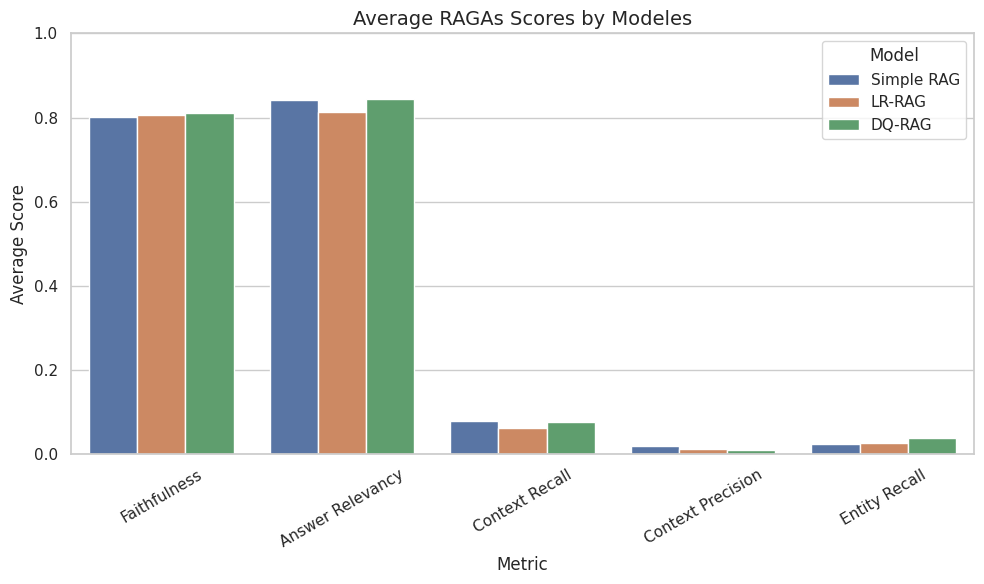

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

def plot_summary_bar(summary_df):
    # Melt DataFrame to long format
    plot_df = summary_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=plot_df, x='Metric', y='Score', hue='Model')
    plt.title('Average RAGAs Scores by Modeles', fontsize=14)
    plt.xticks(rotation=30)
    plt.ylabel('Average Score')
    plt.ylim(0, 1)
    plt.legend(title='Model', loc='upper right')
    plt.tight_layout()
    plt.show()

plot_summary_bar(summary_df)
